# Previsão de Tarifas em Corridas de Táxi com Keras

- O problema que abordaremos é idêntico ao que foi apresentado no projeto [Previsão de Tarifas em Corridas de Táxi](https://medium.com/@omarca2015c/previsão-de-tarifas-em-corridas-de-táxi-911506cc1117), utilizando o mesmo conjunto de dados que contém 150000 linhas.

## 1. Problema de Negócio

- Imagine que você trabalha para uma empresa de táxi e que uma das maiores reclamações de seus clientes é que eles não sabem quanto custará uma corrida até que ela termine.Isso porque a distância é apenas um dos vários fatores a partir dos quais as tarifas de táxi são calculadas.


- Neste contexto, adotaremos uma rede neural como nosso modelo de regressão para efetuar essas previsões.

## 2. Importar bibliotecas e conjunto de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

df = pd.read_csv('taxi_tarifas.csv')

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) # conversão da variável pickup_datetime para datetime

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### Metadados:

>  - key: deve ser usado apenas como um campo de ID exclusivo
>  - fare_amount: valor em dólares do custo da corrida de táxi (target)
>  - pickup_datetime: data/hora que indica quando a corrida de táxi começou
>  - pickup_longitude: coordenada de longitude de onde a corrida de táxi começou
>  - pickup_latitude: coordenada de latitude de onde a corrida de táxi começou
>  - dropoff_longitude: coordenada de longitude de onde a corrida de táxi terminou  
>  - dropoff_latitude: coordenada de latitude de onde a corrida de táxi terminou
>  - passenger_count: número de passageiros na corrida de táxi

## 3. Pré-processamento 

- Os dados requerem de preparação  antes de se tornarem úteis, o que é uma prática comum tanto em aprendizado de máquina quanto em aprendizado profundo. Para realizar essa preparação, utilizaremos as seguintes declarações, conforme detalhado no projeto [Previsão de Tarifas em Corridas de Táxi](https://medium.com/@omarca2015c/previsão-de-tarifas-em-corridas-de-táxi-911506cc1117), a fim de transformar o conjunto de dados bruto em um formato adequado para treinamento.

In [2]:
# Descarte de variáveis não importantes
df = df.drop(['key'], axis=1)

# Remoção das linhas com zero passageiros
df = df[df['passenger_count'] >= 1]

# Criando novas colunas de dados a partir das informações contidas em outras colunas
for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'dia'] = dt.weekday()
    df.at[i, 'hora'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6 # 1 grau == 54.6 milhas
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0   # 1 grau == 69 milhas
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distancia'] = distance
    
# Eliminação das colunas que já não são necessárias
df.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count' ], inplace=True)
    
# Aplicando limites razoáveis às tarifas e distâncias, com base na detecção de outliers
df = df[(df['distancia'] > 0) & (df['distancia'] < 10)]
df = df[(df['fare_amount'] > 3) & (df['fare_amount'] < 45)]

df.head()


,fare_amount,dia,hora,distancia
0,4.5,0.0,17.0,0.641024
1,16.9,1.0,16.0,5.275538
2,5.7,3.0,0.0,0.872636
3,7.7,5.0,4.0,1.738444
4,5.3,1.0,7.0,1.253707


- O conjunto de dados resultante possui colunas que representam o dia da semana (variando de 0 a 6, onde 0 corresponde a segunda-feira), a hora do dia (variando de 0 a 23) e a distância percorrida em milhas. 

## 4. Modelo de regressão com Keras

- Iremos construir um modelo com duas camadas ocultas, cada uma contendo 512 neurônios, e uma camada de entrada que aceita três valores (distância, dia da semana e hora do dia). Dado que o objetivo do modelo é prever o valor da tarifa, a camada de saída será composta por um único neurônio.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Construção da arquitetura da rede
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))

# Definição do otimizador e da função de perda
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Resumo da rede
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2048      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 265,217
Trainable params: 265,217
Non-trainable params: 0
_________________________________________________________________


## Definição do Mini-Batch, e ajuste do modelo

- Estabelecemos a proporção de validação (validation_split) em 0,3, reservando assim  30% dos dados de treinamento para fins de validação. O treinamento do modelo ocorre ao longo de 100 épocas, com um tamanho de lote (batch size) de 100.

In [4]:
x = df.drop('fare_amount', axis=1)
y = df['fare_amount']

hist = model.fit(x, y, validation_split=0.3, epochs=100, batch_size=100)

Epoch 1/100
980/980 [==============================] - 12s 12ms/step - loss: 2.0578 - mae: 2.0578 - val_loss: 1.9866 - val_mae: 1.9866
Epoch 2/100
980/980 [==============================] - 11s 11ms/step - loss: 1.9558 - mae: 1.9558 - val_loss: 1.9331 - val_mae: 1.9331
Epoch 3/100
980/980 [==============================] - 11s 11ms/step - loss: 1.9440 - mae: 1.9440 - val_loss: 1.9436 - val_mae: 1.9436
Epoch 4/100
980/980 [==============================] - 11s 11ms/step - loss: 1.9388 - mae: 1.9388 - val_loss: 1.9324 - val_mae: 1.9324
Epoch 5/100
980/980 [==============================] - 11s 11ms/step - loss: 1.9334 - mae: 1.9334 - val_loss: 1.9327 - val_mae: 1.9327
Epoch 6/100
980/980 [==============================] - 11s 11ms/step - loss: 1.9291 - mae: 1.9291 - val_loss: 1.9143 - val_mae: 1.9143
Epoch 7/100
980/980 [==============================] - 11s 12ms/step - loss: 1.9249 - mae: 1.9249 - val_loss: 1.9133 - val_mae: 1.9133
Epoch 8/100
980/980 [==============================] - 

## Gráfico da Precisão de Treinamento e Precisão de Validação ao Longo do Tempo

[]

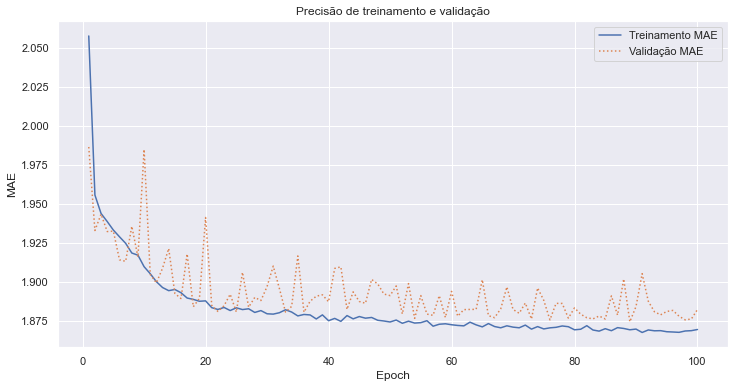

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.figure(figsize=(12,6))
plt.plot(epochs, err, '-', label='Treinamento MAE')
plt.plot(epochs, val_err, ':', label='Validação MAE')
plt.title('Precisão de treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.plot()

- A validação final resultou em um Erro Absoluto Médio (MAE) de aproximadamente 1,85, o que indica que, em média, as estimativas de tarifas de táxi feitas por esta rede devem ter uma precisão de cerca de 1,85 dólares.

## Calculando Métricas de Avaliação

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

MAE = mean_absolute_error(y, model.predict(x))
RMSE = mean_squared_error(y, model.predict(x))**0.5

print(f"O valor do MAE foi de {MAE:.4f} dólares")
print(f"O valor do RMSE foi de {RMSE:.4f} dólares")

4374/4374 [==============================] - 12s 3ms/step
O valor do MAE foi de 1.8711 dólares
O valor do RMSE foi de 3.0543 dólares


- O modelo está errando mais ou menos 3.05 dólares e 1.87 dólares em termos absolutos.

## Utilizando o modelo para prever os valores das tarifas

In [7]:
# Prevendo o valor da tarifa para uma viagem de 3 milhas feita às 16:00 no dia sábado

model.predict(np.array([[5, 16, 3.0]]))

1/1 [==============================] - 0s 64ms/step


array([[13.484056]], dtype=float32)

- O custo de uma viagem de 3 milhas realizada às 16:00 horas de um sábado foi aproximadamente de 13 dólares.

In [8]:
# Prevendo o valor da tarifa para uma viagem de 8 milhas feita às 11:00 a.m. na segunda-feira

model.predict(np.array([[11, 11, 8.0]]))


1/1 [==============================] - 0s 25ms/step


array([[27.434412]], dtype=float32)

## 5. Conclusão

- O modelo atingiu um desempenho consistente, com pouca variação no Erro Absoluto Médio (MAE) tanto no conjunto de treinamento quanto no conjunto de validação. O modelo está errando mais ou menos 3.05 dólares e 1.87 dólares em termos absolutos.


- É possível realizar a normalização das features e  modificar o número de neurônios, adicionar mais camadas ocultas ou aumentar o número de épocas, que podem ser testadas para ver o impacto no desempenho do modelo. 